In [77]:
%pylab inline
from vplot import *
import pandas as pd
import os
import scipy.stats
import seaborn as sns

locus = "ATN1"
CHROM=12
START=7045880
RSIDS=["rs4963516","rs1007924","rs7310941",
       "rs7303722", "rs2239167","rs34199021","rs2071075",
    "rs2071076","rs2159887"]
RISKALLELES = ["G","A","G","T","A","A","T","C","C"]

OUTPATH="pdfs/"
PREFIX="Figure5"
DATADIR="/storage/mgymrek/ssc-imputation/"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Figure 4A: haplotype structure

In [78]:
# Write snplist
RSIDS_all = RSIDS
f = open("snplist_%s.txt"%locus, "w")
for rs in RSIDS_all:
    f.write(rs+"\n")
f.close()

In [79]:
%%bash -s "$CHROM" "$START" "$locus"
CHROM=$1
START=$2
LOCUS=$3
WINDOW=100000
#VCF=/storage/s1saini/hipstr_allfilters/str_snp/chr${CHROM}.str.snp.feb18.vcf.gz
VCF=/storage/s1saini/manuscript_strsnp/fig3/1kg.panel/1kg.snp.str.chr${CHROM}.vcf.gz

WSTART=$((START-$WINDOW))
WEND=$((START+$WINDOW))

# Extract snp list
bcftools query -r ${CHROM}:${WSTART}-${WEND} \
     -f "%ID\t%CHROM\t%POS\t%REF\n" \
     $VCF | \
     grep -f snplist_${LOCUS}.txt | \
     awk '(length($4)==1)' | awk '{print $2 "\t" $3-1 "\t" $3}' > snp_loci_${LOCUS}.bed

# Add best SNP for each allele 
#for allele in -21 -15 -9 -6 -3 0 3 6 9 15
#do
#     cat snp_loci_alleler2_${LOCUS}.tab | awk -v"allele=$allele" '($3==allele)' | \
#        sort -k 7 -g -r | head -n 1 | cut -f 2 | sed 's/:/\t/' | \
#        awk '{print $1 "\t" $2-1 "\t" $2}' >> snp_loci_${LOCUS}.bed
#done
#cat snp_loci_${LOCUS}.bed | sort | uniq > del
#mv del snp_loci_${LOCUS}.bed

# Extract haplotypes 
echo "Extracting haplotypes"
bcftools query -r ${CHROM}:${WSTART}-${WEND} \
     -S 1kg_eur_samples.txt \
     -R snp_loci_${LOCUS}.bed \
     -f "%ID\t%POS\t%REF\t%ALT\t[%GT\t]\n" \
     $VCF | \
     awk '(length($3)==1)' | sed 's/|/\t/g' > haplotypes_${LOCUS}.tab
bcftools query -r ${CHROM}:${START}-${START} \
     -S 1kg_eur_samples.txt \
     -f "%ID\t%POS\t%REF\t%ALT\t[%GT\t]\n" ${VCF} | \
     awk -v"start=$START" '($2==start)' | \
     sed 's/|/\t/g' >> haplotypes_${LOCUS}.tab

Extracting haplotypes


In [80]:
def PlotHapmaptrix(hapmatrix, ar2, allele, allsnps, fname):
    box_w =  1.0/len(allsnps)
    box_h = box_w
    hap_height = hapmatrix.shape[0]*0.0025
    legend_height = 0
    fig = plt.figure()
    fig.set_size_inches(3, hap_height + legend_height)
    #gs = gridspec.GridSpec(2, 1, height_ratios=[hap_height, legend_height]) 
    ax = fig.add_subplot(111)
    # Plot SNPs
    imx = ax.imshow(hapmatrix, cmap=plt.cm.Greys.from_list("snp", ["lightgray","black"]), 
              aspect="auto", extent=(0, hapmatrix.shape[1], box_h, hapmatrix.shape[0]-box_h))
    ax.set_yticks([]);
    ax.set_yticklabels([]);
    ax.set_xticks([]);
    ax.set_xticklabels([]);
    ax.set_title("STR allele %s"%allele)
    fig.savefig(fname)

In [81]:
import vcf

# Load list of loci to restrict to
usesnps = pd.read_csv("snp_loci_%s.bed"%locus, sep="\t", names=["chrom","start","snppos"])
# Load allele r2
ar2 = pd.read_csv("snp_loci_alleler2_%s.tab"%locus, sep="\t")
ar2["snppos"] = ar2["locus2"].apply(lambda x: int(x.split(":")[1]))
ar2 = pd.merge(ar2, usesnps, on=["snppos"])

chrom=ar2["locus1"].values[0].split(":")[0]
# Convert snp pos to rsid
reader = vcf.Reader(open("/storage/s1saini/hipstr_allfilters/str_snp/chr%s.str.snp.feb18.vcf.gz"%chrom, "rb"))
rsids = []
for i in range(ar2.shape[0]):
    start = int(ar2["locus2"].values[i].split(":")[1])
    records = reader.fetch(chrom, start-1, start)
    rid = None
    for r in records:
        rid = r.ID.replace("_","")
        break
    rsids.append(rid)
ar2["rsid"] = rsids
ar2["pos"] = ar2["locus2"].apply(lambda x: "pos"+x.split(":")[1])
ar2 = ar2[ar2["MAF"]>=0.05]

-21:(119, 9)
-15:(119, 9)
-9:(21, 9)
-6:(10, 9)
-3:(39, 9)
0:(377, 9)
3:(202, 9)
6:(59, 9)
9:(14, 9)
15:(21, 9)
max:(26, 9)


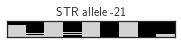

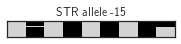

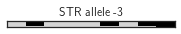

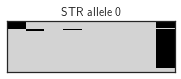

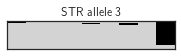

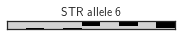

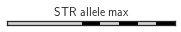

In [82]:
# Read in haplotypes
numhaps = 503*2
colnames = ["id","pos","ref","alt"] + ["hap_%s"%i for i in range(numhaps)]
haplotypes = pd.read_csv("haplotypes_%s.tab"%(locus), sep="\t",
                        names=colnames, usecols=range(len(colnames)))
haplotypes["vartype"] = haplotypes.apply(lambda x: ["SNP","STR"][int(len(x["ref"])>1)], 1)
haplotypes.index = ["pos"+str(haplotypes["pos"].values[i]) for i in range(haplotypes.shape[0]-1)] + ["STR"]

# Annotate STR lengths
ref = haplotypes[haplotypes["vartype"]=="STR"]["ref"].values[0]
alt = haplotypes[haplotypes["vartype"]=="STR"]["alt"].values[0].split(",")
str_allele_lengths = [len(ref)] + [len(item) for item in alt]
str_allele_lengths = [item-len(ref) for item in str_allele_lengths]
for i in range(numhaps):
    col = "hap_%s"%i
    gtlen = str_allele_lengths[haplotypes[haplotypes["vartype"]=="STR"][col].values[0]]
    haplotypes.loc["STR", col] = gtlen

# Reaad in allele-r2
hapcols = colnames[4:]
haplotype_filt = haplotypes[hapcols].transpose()

allsnps = [item for item in haplotype_filt.columns if "pos" in item]
ar2hap = ar2[ar2["pos"].apply(lambda x: x in allsnps)]
best_ar2 = ar2hap.groupby("pos", as_index=False).agg({"r2": max}).sort_values("r2", ascending=True)

# Get haplotype matrix, sort by allele-r2
haplotype_filt = haplotype_filt.sort_values(by="STR")
haplotype_filt = haplotype_filt.sort_values(["STR"]+list(best_ar2["pos"].values), ascending=False)

for allele in sorted(list(set(str_allele_lengths)))+["max"]:
    if allele == "max":
        hapmatrix = np.matrix(haplotype_filt[haplotype_filt["STR"]>=15][allsnps])
    else: hapmatrix = np.matrix(haplotype_filt[haplotype_filt["STR"]==allele][allsnps])
    if hapmatrix.shape[0]>= 10:
        sys.stderr.write("%s:%s\n"%(allele, hapmatrix.shape))
        fname = os.path.join(OUTPATH, "%s_Haplotypes_%s.pdf"%(PREFIX,allele))
        PlotHapmaptrix(hapmatrix, ar2, allele, allsnps, fname)

6948028
7076236


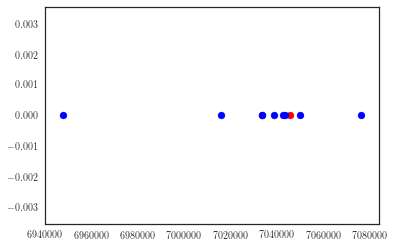

In [83]:
fig = plt.figure()
ax = fig.add_subplot(111)
# Plot SNPs
snps = haplotypes[haplotypes["vartype"]!="STR"]
ax.scatter(snps["pos"], [0]*snps.shape[0], color="gray", s=2)
# Plot STR
strs = haplotypes[haplotypes["vartype"]=="STR"]
ax.scatter(strs["pos"], [0]*strs.shape[0], color="red")
# Risk haplotype snps
rsnps = haplotypes[haplotypes["id"].apply(lambda x: x in RSIDS)]
ax.scatter(rsnps["pos"], [0]*rsnps.shape[0], color="blue")
fig.savefig(os.path.join(OUTPATH, "%s_Positions.pdf"%PREFIX))
print(min(rsnps["pos"]))
print(max(rsnps["pos"]))

6948028
7076236


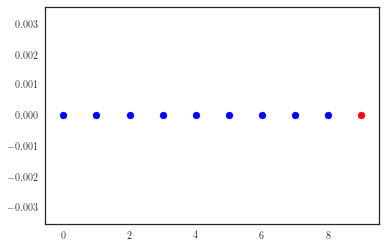

In [84]:
fig = plt.figure()
ax = fig.add_subplot(111)
haplotypes["xpos"] = range(haplotypes.shape[0])
# Plot SNPs
snps = haplotypes[haplotypes["vartype"]!="STR"]
ax.scatter(snps["xpos"], [0]*snps.shape[0], color="gray", s=2)
# Plot STR
strs = haplotypes[haplotypes["vartype"]=="STR"]
ax.scatter(strs["xpos"], [0]*strs.shape[0], color="red")
# Risk haplotype snps
rsnps = haplotypes[haplotypes["id"].apply(lambda x: x in RSIDS)]
ax.scatter(rsnps["xpos"], [0]*rsnps.shape[0], color="blue")
fig.savefig(os.path.join(OUTPATH, "%s_XPositions.pdf"%PREFIX))
print(min(rsnps["pos"]))
print(max(rsnps["pos"]))

## Figure 4B: Bubbles

(0.9237198906174469, 0.0)

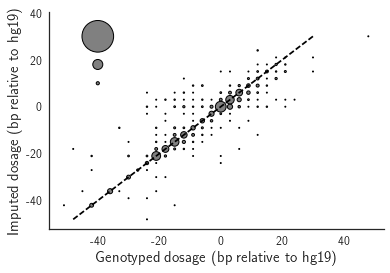

In [85]:
LOODIR="/storage/s1saini/manuscript_strsnp/fig3/loo_pathogenic/"
# Get LOO results
cmd="""cat %s/%s_%s/*.diff.txt | cut -d' ' -f 1,2,3,5,6 > ssc_res_%s.tab"""%(LOODIR,CHROM,START,locus)
os.system(cmd)

# Load results and plot
# Bubble plot
d = pd.read_csv("ssc_res_%s.tab"%locus, sep=" ", names=["strid","true_1","true_2","impute_1","impute_2"])
d["sum_true"] = d["true_1"]+d["true_2"]
d["sum_imp"] = d["impute_1"] + d["impute_2"]
bubbles = d.groupby(["sum_true","sum_imp"], as_index=False).agg({"strid": len})

# Bubble chart of obs vs. exp
minval=max([min(bubbles["sum_true"]),min(bubbles["sum_imp"])])
maxval=min([max(bubbles["sum_true"]),max(bubbles["sum_imp"])])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(bubbles["sum_true"], bubbles["sum_imp"], s=bubbles["strid"],
           color="gray", edgecolor="black", linewidth=1)
ax.plot([minval,maxval], [minval,maxval], color="black", linestyle="dashed")

# Plot legend
xvals = [-40]*3
yvals = [10, 18, 30]
sizes = [10, 100, 1000]
ax.scatter(xvals, yvals, s=sizes, color="gray", edgecolor="black", linewidth=1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Genotyped dosage (bp relative to hg19)", size=15)
ax.set_ylabel("Imputed dosage (bp relative to hg19)", size=15)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);

fig.savefig(os.path.join(OUTPATH, "%s_bubbles.pdf"%PREFIX))
scipy.stats.pearsonr(d["sum_true"], d["sum_imp"])

## Figure 4C: SNP R2 heatmap

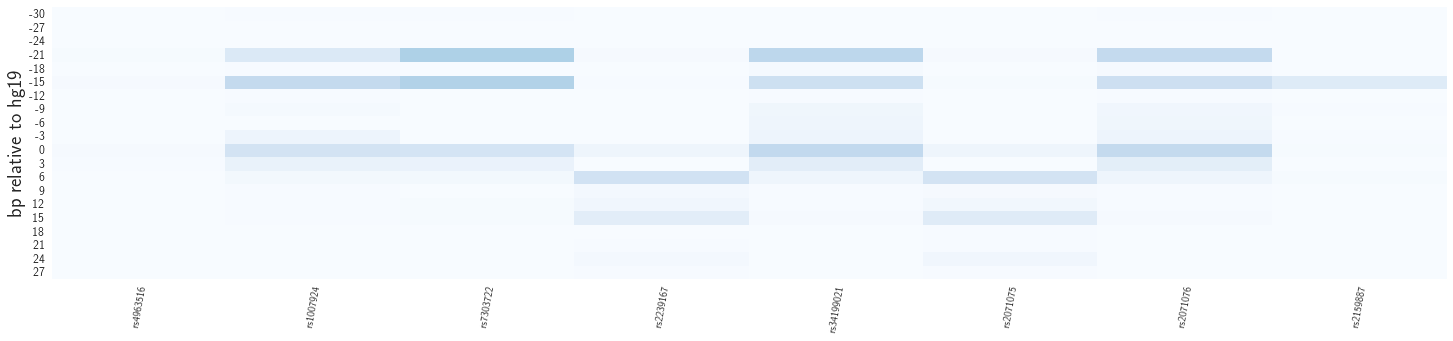

In [86]:
# Make matrix of allele num vs. SNP
sub = ar2[ar2["MAF"]>=0.05]
alleles = sorted(list(set(sub["allele"])))
snps = sorted(list(set(sub["snppos"])))
rsids = [sub[sub["snppos"]==item]["rsid"].values[0] for item in snps]

data = np.zeros((len(alleles), len(snps)))
for i in range(len(alleles)):
    for j in range(len(snps)):
        r2 = sub[(sub["allele"]==alleles[i]) & (sub["snppos"]==snps[j])]["r2"].values[0]
        data[i,j] = r2

fig = plt.figure()
fig.set_size_inches((25, 5))
ax = fig.add_subplot(111)
sns.heatmap(data, cmap=plt.cm.Blues, vmin=0, vmax=1, yticklabels=alleles, xticklabels=rsids, ax=ax, cbar=False);
ax.set_xticklabels(ax.get_xticklabels(), rotation=80, size=10);
ax.set_yticklabels(ax.get_yticklabels(), size=12, rotation=0);
ax.set_ylabel("bp relative to hg19", size=20);
fig.savefig(os.path.join(OUTPATH, "%s_alleler2.pdf"%PREFIX))

## Figure 4D: Risk haplotype

In [87]:
# File of SNP RSIDs to check
f = open("snplist.txt","w")
for r in RSIDS: f.write(r+"\n")
f.close()

In [88]:
%%bash -s "$CHROM" "$START" "$locus"
CHROM=$1
START=$2
LOCUS=$3
WINDOW=100000
VCF=/storage/s1saini/hipstr_allfilters/str_snp/chr${CHROM}.str.snp.feb18.vcf.gz

WSTART=$((START-$WINDOW))
WEND=$((START+$WINDOW))

# Extract haplotypes - risk haplotype SNPs
echo "Extracting haplotypes"
bcftools query -r ${CHROM}:${WSTART}-${WEND} \
     -f "%ID\t%POS\t%REF\t%ALT\t[%GT\t]\n" \
     $VCF | \
     grep -f snplist.txt | \
     awk '(length($3)==1)' | sed 's/|/\t/g' > haplotypes_${LOCUS}_risk.tab
bcftools query -r ${CHROM}:${START}-${START} \
    -f "%ID\t%POS\t%REF\t%ALT\t[%GT\t]\n" ${VCF} | \
    awk -v"start=$START" '($2==start)' | \
    sed 's/|/\t/g' >> haplotypes_${LOCUS}_risk.tab

Extracting haplotypes


In [89]:
# Read in haplotypes
numhaps = 1916*2
colnames = ["id","pos","ref","alt"] + ["hap_%s"%i for i in range(numhaps)]
haplotypes = pd.read_csv("haplotypes_%s_risk.tab"%locus, sep="\t",
                        names=colnames, usecols=range(len(colnames)))
haplotypes["vartype"] = haplotypes.apply(lambda x: ["SNP","STR"][int(len(x["ref"])>1)], 1)
haplotypes.index = haplotypes["id"]

strind = haplotypes[haplotypes["vartype"]=="STR"].index.values[0]
# Annotate STR lengths
ref = haplotypes[haplotypes["vartype"]=="STR"]["ref"].values[0]
alt = haplotypes[haplotypes["vartype"]=="STR"]["alt"].values[0].split(",")
str_allele_lengths = [len(ref)] + [len(item) for item in alt]
str_allele_lengths = [item-len(ref) for item in str_allele_lengths]
for i in range(numhaps):
    col = "hap_%s"%i
    gtlen = str_allele_lengths[int(haplotypes[haplotypes["vartype"]=="STR"][col].values[0])]
    haplotypes.loc[strind, col] = gtlen

In [90]:
risk_alleles = dict(zip(RSIDS,RISKALLELES))
risk_alleles_binary = {}
for rsid in RSIDS:
    ref = haplotypes.loc[rsid,"ref"]
    alt = haplotypes.loc[rsid,"alt"]
    if ref == risk_alleles[rsid]: risk_alleles_binary[rsid] = 0
    elif alt == risk_alleles[rsid]: risk_alleles_binary[rsid] = 1
    else: print("Error %s"%rsid)

In [91]:
hapdists = [] # dist from risk haplotype
strlens = []
hap = []
for col in haplotypes.columns:
    if "hap" not in col: continue
    dist = 0
    for rs in RSIDS:
        val = haplotypes.loc[rs, col]
        if val != risk_alleles_binary[rs]:
            dist += 1
    hapdists.append(dist)
    strlens.append(haplotypes.loc[strind,col])
    hap.append(col)
hdata = pd.DataFrame({"strlen": strlens, "hapdists": hapdists, "hap":hap})

/usr/lib/python3.4/site-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/lib/python3.4/site-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


(-0.7892188013975399, 0.0)


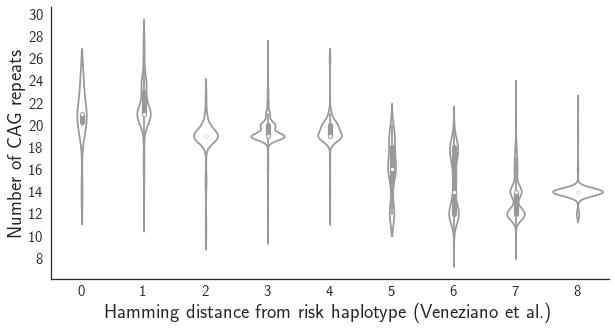

In [98]:
sns.set_style("white")
fig = plt.figure()
fig.set_size_inches((10, 5))
ax = fig.add_subplot(111)
ax = sns.violinplot(x="hapdists", y="strlen", data=hdata,  whis=np.inf, inner="box", color="white")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Hamming distance from risk haplotype (Veneziano et al.)", size=20)
ax.set_ylabel("Number of CAG repeats", size=20)
ax.set_xticklabels(ax.get_xticks(), size=15)
ax.set_yticks(np.arange(-33, 34, 6))
ax.set_yticklabels([int(19+item/3) for item in ax.get_yticks()], size=15);
print(scipy.stats.pearsonr(hdata["strlen"],hdata["hapdists"]))
fig.savefig(os.path.join(OUTPATH, "%s_RiskHaplotype.pdf"%PREFIX))